In [1]:
import os
os.chdir( "../")

In [2]:
import pandas as pd
import numpy as np

path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])


df

,UserID,ItemID,Interaction
0,1,15,1.0
1,1,16,1.0
2,1,133,1.0
3,1,161,1.0
4,1,187,1.0
...,...,...,...
478724,13024,13605,1.0
478725,13024,13823,1.0
478726,13024,15122,1.0
478727,13024,18185,1.0


In [3]:
df.Interaction.value_counts()

1.0    478729
Name: Interaction, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478729 entries, 0 to 478728
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UserID       478729 non-null  int64  
 1   ItemID       478729 non-null  int64  
 2   Interaction  478729 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [5]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [6]:
df.head()

,UserID,ItemID,Interaction,User,Item
0,1,15,1.0,0,0
1,1,16,1.0,0,1
2,1,133,1.0,0,2
3,1,161,1.0,0,3
4,1,187,1.0,0,4


In [7]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample



urm_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

urm_train_validation, urm_test = split_train_in_two_percentage_global_sample(urm_all, train_percentage = 0.80)
urm_train, urm_validation = split_train_in_two_percentage_global_sample(urm_train_validation, train_percentage = 0.80)

In [9]:
num_users = len(userId_unique)
num_items = len(itemId_unique)

In [10]:
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10], ignore_users=[])

2023-12-08 21:49:32.588146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-08 21:49:32.588180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


EvaluatorHoldout: Ignoring 2602 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


## Insert model here

In [11]:
model = RP3betaRecommender

In [12]:
import optuna as op

def objective(trial):
    topK = trial.suggest_int("topK", 5, 1500)
    #l1 = trial.suggest_float("l1_ratio", 0.01, 0.1)
    alpha = trial.suggest_float("alpha", 0.1, 1) # maybe [0.5-1]?
    beta = trial.suggest_float("beta", 0, 0.4)
    normalize_similarity = trial.suggest_categorical("normalize_similarity",[True,False])

    
    recommender = model(urm_train)
    recommender.fit(**trial.params)
    
    result, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_result = result["MAP"].item()
       
    return MAP_result

In [13]:
best_params = {'topK': 46,
 'alpha': 0.8604387480969916,
 'beta': 0.1537736651871471,
 'normalize_similarity': True}

skiopt_params = {'topK': 41, 'alpha': 0.24025759098180052, 'beta': 0.21463311953617964, 'normalize_similarity': True}


study = op.create_study(direction="maximize")
study.enqueue_trial(best_params)

study.enqueue_trial(skiopt_params)

study.optimize(objective, n_trials=30)

[I 2023-12-08 21:49:33,287] A new study created in memory with name: no-name-7b0ec48f-76aa-4c14-b40c-c11237650e4c


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8167.10 column/sec. Elapsed time 2.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.52 sec. Users per second: 3982


[I 2023-12-08 21:49:39,034] Trial 0 finished with value: 0.026549311367964273 and parameters: {'topK': 46, 'alpha': 0.8604387480969916, 'beta': 0.1537736651871471, 'normalize_similarity': True}. Best is trial 0 with value: 0.026549311367964273.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8403.38 column/sec. Elapsed time 2.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.33 sec. Users per second: 4314


[I 2023-12-08 21:49:44,535] Trial 1 finished with value: 0.030084042684431538 and parameters: {'topK': 41, 'alpha': 0.24025759098180052, 'beta': 0.21463311953617964, 'normalize_similarity': True}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 4675.15 column/sec. Elapsed time 4.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.09 sec. Users per second: 3250


[I 2023-12-08 21:49:54,248] Trial 2 finished with value: 0.01886272909588971 and parameters: {'topK': 300, 'alpha': 0.9277368580609887, 'beta': 0.03357694998318159, 'normalize_similarity': False}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2703.37 column/sec. Elapsed time 8.22 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.71 sec. Users per second: 2131


[I 2023-12-08 21:50:12,063] Trial 3 finished with value: 0.02259310925114044 and parameters: {'topK': 1100, 'alpha': 0.7775638081230689, 'beta': 0.03692313946614001, 'normalize_similarity': False}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 4739.76 column/sec. Elapsed time 4.69 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.32 sec. Users per second: 3021


[I 2023-12-08 21:50:22,159] Trial 4 finished with value: 0.026093472230130362 and parameters: {'topK': 258, 'alpha': 0.42480147342287844, 'beta': 0.2984572481562814, 'normalize_similarity': True}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 3455.70 column/sec. Elapsed time 6.43 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.11 sec. Users per second: 2441


[I 2023-12-08 21:50:36,213] Trial 5 finished with value: 0.019323676826915194 and parameters: {'topK': 569, 'alpha': 0.3934571683404423, 'beta': 0.16461727680607977, 'normalize_similarity': False}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 3582.95 column/sec. Elapsed time 6.20 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.10 sec. Users per second: 2446


[I 2023-12-08 21:50:50,066] Trial 6 finished with value: 0.022071147045240345 and parameters: {'topK': 559, 'alpha': 0.20915524657441756, 'beta': 0.36654408012661593, 'normalize_similarity': False}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2821.38 column/sec. Elapsed time 7.88 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.43 sec. Users per second: 2267


[I 2023-12-08 21:51:07,052] Trial 7 finished with value: 0.019943153061676374 and parameters: {'topK': 1042, 'alpha': 0.5838332686262936, 'beta': 0.13260200172656728, 'normalize_similarity': False}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2606.32 column/sec. Elapsed time 8.53 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.15 sec. Users per second: 1949


[I 2023-12-08 21:51:26,271] Trial 8 finished with value: 0.021278405676074107 and parameters: {'topK': 1258, 'alpha': 0.5913791835408504, 'beta': 0.3588009843510101, 'normalize_similarity': True}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 5462.41 column/sec. Elapsed time 4.07 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.96 sec. Users per second: 3392


[I 2023-12-08 21:51:34,640] Trial 9 finished with value: 0.01423881170642825 and parameters: {'topK': 184, 'alpha': 0.9543564927395157, 'beta': 0.08818774918293482, 'normalize_similarity': False}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2868.41 column/sec. Elapsed time 7.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.31 sec. Users per second: 2331


[I 2023-12-08 21:51:51,320] Trial 10 finished with value: 0.023261809074632926 and parameters: {'topK': 791, 'alpha': 0.12625302645469944, 'beta': 0.2487085118542921, 'normalize_similarity': True}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 9079.46 column/sec. Elapsed time 2.45 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.39 sec. Users per second: 4202


[I 2023-12-08 21:51:56,513] Trial 11 finished with value: 0.025805682874983405 and parameters: {'topK': 14, 'alpha': 0.7610079319664608, 'beta': 0.20508746094028216, 'normalize_similarity': True}. Best is trial 1 with value: 0.030084042684431538.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8225.35 column/sec. Elapsed time 2.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.45 sec. Users per second: 4104


[I 2023-12-08 21:52:02,225] Trial 12 finished with value: 0.030100590256030926 and parameters: {'topK': 47, 'alpha': 0.2940366325176169, 'beta': 0.21247673810899353, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 3656.95 column/sec. Elapsed time 6.08 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.73 sec. Users per second: 2694


[I 2023-12-08 21:52:15,154] Trial 13 finished with value: 0.02465971708199694 and parameters: {'topK': 461, 'alpha': 0.2621375249674994, 'beta': 0.2391873297049218, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2986.42 column/sec. Elapsed time 7.44 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.38 sec. Users per second: 2291


[I 2023-12-08 21:52:31,441] Trial 14 finished with value: 0.023044456622824568 and parameters: {'topK': 776, 'alpha': 0.10054655658713016, 'beta': 0.2851772111299162, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 3978.06 column/sec. Elapsed time 5.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.37 sec. Users per second: 2981


[I 2023-12-08 21:52:43,201] Trial 15 finished with value: 0.02510550114824727 and parameters: {'topK': 396, 'alpha': 0.2887601450365262, 'beta': 0.2249503425914379, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6357.18 column/sec. Elapsed time 3.50 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.84 sec. Users per second: 3528


[I 2023-12-08 21:52:50,690] Trial 16 finished with value: 0.02881472334516391 and parameters: {'topK': 127, 'alpha': 0.37260594991625245, 'beta': 0.18101625815612327, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2466.32 column/sec. Elapsed time 9.01 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.93 sec. Users per second: 2036


[I 2023-12-08 21:53:10,451] Trial 17 finished with value: 0.02344113967494798 and parameters: {'topK': 1484, 'alpha': 0.4815156585672878, 'beta': 0.12242704973488452, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 4317.50 column/sec. Elapsed time 5.15 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.36 sec. Users per second: 2987


[I 2023-12-08 21:53:21,339] Trial 18 finished with value: 0.025785224778100475 and parameters: {'topK': 318, 'alpha': 0.2090466267130442, 'beta': 0.18767328911005718, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 3280.21 column/sec. Elapsed time 6.77 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.14 sec. Users per second: 2422


[I 2023-12-08 21:53:36,217] Trial 19 finished with value: 0.023957471357082816 and parameters: {'topK': 628, 'alpha': 0.3148156482808959, 'beta': 0.3029531214257346, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 2834.34 column/sec. Elapsed time 7.84 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.52 sec. Users per second: 2221


[I 2023-12-08 21:53:53,581] Trial 20 finished with value: 0.023187224404841077 and parameters: {'topK': 911, 'alpha': 0.18956415053312706, 'beta': 0.25352655190221485, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6161.72 column/sec. Elapsed time 3.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.61 sec. Users per second: 3844


[I 2023-12-08 21:54:00,999] Trial 21 finished with value: 0.028503577596842033 and parameters: {'topK': 135, 'alpha': 0.3167272167690527, 'beta': 0.18263878851600726, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6371.66 column/sec. Elapsed time 3.49 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.88 sec. Users per second: 3482


[I 2023-12-08 21:54:08,618] Trial 22 finished with value: 0.028549614245858015 and parameters: {'topK': 131, 'alpha': 0.3474207583176095, 'beta': 0.2012106023937674, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 10055.27 column/sec. Elapsed time 2.21 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.26 sec. Users per second: 4448


[I 2023-12-08 21:54:13,302] Trial 23 finished with value: 0.02357193073190481 and parameters: {'topK': 5, 'alpha': 0.4695461548588117, 'beta': 0.21596408246752374, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 5682.07 column/sec. Elapsed time 3.91 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.96 sec. Users per second: 3387


[I 2023-12-08 21:54:21,756] Trial 24 finished with value: 0.027933914099717357 and parameters: {'topK': 187, 'alpha': 0.37090905916465106, 'beta': 0.16654587694833822, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 3882.47 column/sec. Elapsed time 5.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.51 sec. Users per second: 2857


[I 2023-12-08 21:54:33,816] Trial 25 finished with value: 0.02593573453029415 and parameters: {'topK': 428, 'alpha': 0.2449477099558741, 'beta': 0.10306515408760944, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6592.18 column/sec. Elapsed time 3.37 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.75 sec. Users per second: 3646


[I 2023-12-08 21:54:41,010] Trial 26 finished with value: 0.029152277989713322 and parameters: {'topK': 113, 'alpha': 0.1547267935021711, 'beta': 0.14875126758089302, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 4513.92 column/sec. Elapsed time 4.92 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.10 sec. Users per second: 3242


[I 2023-12-08 21:54:51,038] Trial 27 finished with value: 0.02697613986474102 and parameters: {'topK': 275, 'alpha': 0.1426459759890572, 'beta': 0.07409590334205665, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6941.10 column/sec. Elapsed time 3.20 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.68 sec. Users per second: 3750


[I 2023-12-08 21:54:57,763] Trial 28 finished with value: 0.03004349816849831 and parameters: {'topK': 87, 'alpha': 0.19423777332738565, 'beta': 0.13483066472455368, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8910.89 column/sec. Elapsed time 2.49 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.44 sec. Users per second: 4112


[I 2023-12-08 21:55:03,040] Trial 29 finished with value: 0.02989377526618476 and parameters: {'topK': 23, 'alpha': 0.24622233840038169, 'beta': 0.15024561924279933, 'normalize_similarity': True}. Best is trial 12 with value: 0.030100590256030926.


In [14]:
study.trials_dataframe().to_csv("OPTUNA_RP3BETA_V4.csv")

In [15]:
opt_df = study.trials_dataframe()

In [16]:
study.best_params

{'topK': 47,
 'alpha': 0.2940366325176169,
 'beta': 0.21247673810899353,
 'normalize_similarity': True}

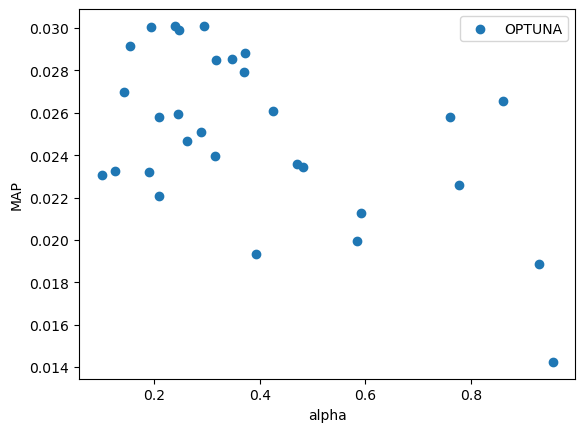

In [17]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_alpha"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.legend()
pyplot.show()

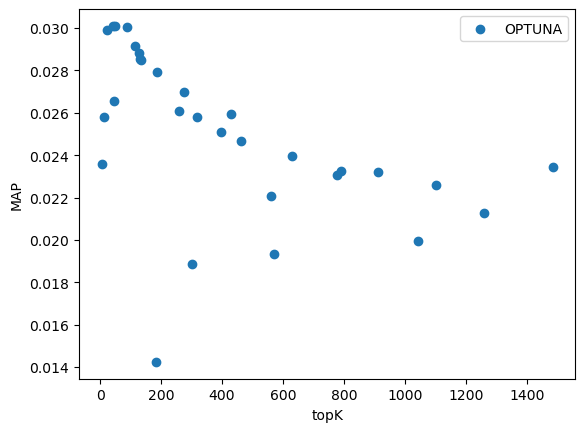

In [18]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_topK"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('topK')
pyplot.legend()
pyplot.show()

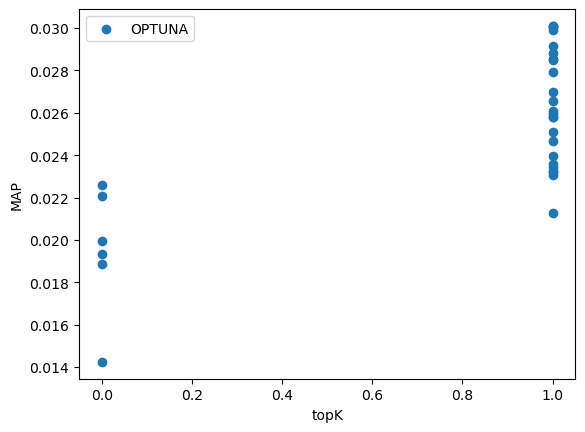

In [19]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_normalize_similarity"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('topK')
pyplot.legend()
pyplot.show()



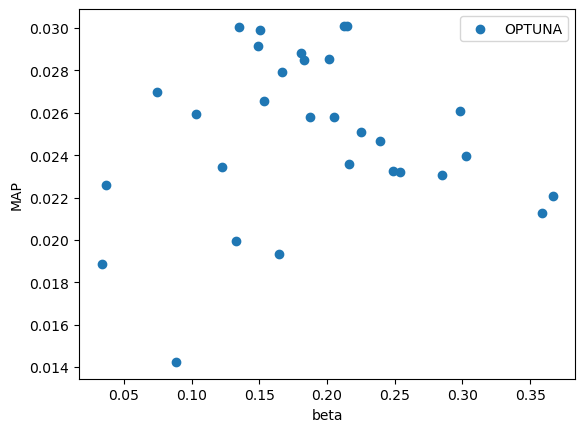

In [20]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_beta"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('beta')
pyplot.legend()
pyplot.show()

In [21]:
study.best_value

0.030100590256030926

In [22]:
study.best_params

{'topK': 47,
 'alpha': 0.2940366325176169,
 'beta': 0.21247673810899353,
 'normalize_similarity': True}

In [23]:
final = model(urm_train_validation)
final.fit(**study.best_params)

RP3betaRecommender: URM Detected 218 ( 1.7%) users with no interactions.
RP3betaRecommender: URM Detected 110 ( 0.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 7172.73 column/sec. Elapsed time 3.10 sec


In [28]:
urm_train_validation[12638]

IndexError: row index (12638) out of range

In [29]:
final.recommend(12638,10)

IndexError: index (12638) out of range

In [24]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10], ignore_users=[])
evaluator_test.evaluateRecommender(final)

EvaluatorHoldout: Ignoring 2128 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Processed 10510 (100.0%) in 2.63 sec. Users per second: 3990


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.093758                  0.16532  0.140026  0.048002    0.084479   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.268784  0.150546  0.112314  0.516746      0.354647  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.831619          0.429736    0.831619       0.087992   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.693311                   0.998287             0.252131   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   